In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.metrics import make_scorer, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
#!pip install imblearn
from imblearn.combine import SMOTETomek
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
#!pip install xgboost
from xgboost import XGBRFClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
#!pip install lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier
#!pip install scikit-optimize
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV
#!pip install shap
import shap
shap.initjs()
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_excel(r"C:\Users\Dell\Downloads\Customer Journey data_DA Assignment.xlsx",sheet_name='Data')
df.head()

,ID,Created At,Updated At,Intro View,Audio Journey,Self Explore,Accessories,EMI,Exchange,Book Now,Finance,Test Drive,Terms & Condition,Model ID,Variant ID,Showroom Price,Accessories price,City,State,Pincode
0,1040781,2022-11-01 00:04:11,2022-11-01 00:21:05,yes,no,no,yes,no,no,no,no,no,no,3,62,2049800,68629.0,Delhi,Delhi,NaN
1,1040782,2022-11-01 00:04:24,2022-11-01 00:04:24,no,no,no,no,no,no,no,no,no,no,3,62,2069800,NaN,Delhi,Delhi,NaN
2,1040783,2022-11-01 00:04:55,2022-11-01 00:04:55,no,no,no,no,no,no,no,no,no,no,3,62,2069800,0.0,Delhi,Delhi,NaN
3,1040784,2022-11-01 00:08:32,2022-11-01 00:31:51,no,no,no,yes,no,no,no,no,no,no,5,85,1455800,21697.0,Delhi,Delhi,NaN
4,1040785,2022-11-01 00:08:34,2022-11-01 00:09:20,no,no,no,no,no,no,no,no,no,no,4,93,4077800,0.0,Delhi,Delhi,NaN


In [4]:
#creating additional variables
df['first_visit']=df.apply(lambda x: 1 if x['Created At']==x['Updated At'] else 0, axis=1)
df['Hour'] = df.apply(lambda x: datetime.datetime.fromisoformat(str(x['Updated At'])).hour,axis=1)
df['Day'] = df.apply(lambda x: datetime.datetime.fromisoformat(str(x['Updated At'])).day,axis=1)
#dropping pincode as it has only 10% non-null
df.drop(columns=['Pincode'],inplace=True)
df['Accessories price'] = df['Accessories price'].fillna(0)
df['days_since_created'] = df.apply(lambda x: (x['Updated At'].date()-x['Created At'].date()).days,axis=1)
for x in df.columns.values[3:13]:
    df[x] = df[x].replace({'yes':1,'no':0})
df['it_city'] = df.apply(lambda x: 1 if x['City'] in ['Delhi','Gurugram','Bengaluru','Chennai','Hyderabad'] else 0,axis=1)
df.drop(columns=['Created At','Updated At','ID','State','City'],inplace=True)

In [18]:
print(df['Book Now'].value_counts())
print('---------------------------------------------------------------')
print("Using SMOTE to fix the imbalance")

X=df.drop(columns=['Book Now'])
Y=df['Book Now']
#splitting the dataset

X_train, X_test, Y_train, Y_test = train_test_split( X,Y , test_size = 0.35, random_state = 0, stratify=Y)

#standardizing
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)
print(f'Before X_train : {X_train.shape}')
print(f'Before Y_train :\n{Y_train.value_counts()}')

#Handling class imbalance by oversampling it using smote and removing tomek links
X_smote, Y_smote = SMOTETomek(random_state=42).fit_resample(X_train,Y_train)
print(f'After X_smote : {X_smote.shape}')
print(f'After Y_smote :\n{Y_smote.value_counts()}')

0    12975
1       51
Name: Book Now, dtype: int64
---------------------------------------------------------------
Using SMOTE to fix the imbalance
Before X_train : (8466, 18)
Before Y_train :
0    8433
1      33
Name: Book Now, dtype: int64
After X_smote : (16646, 18)
After Y_smote :
0    8323
1    8323
Name: Book Now, dtype: int64


In [19]:
Y_test.value_counts()

0    4542
1      18
Name: Book Now, dtype: int64

In [23]:
from sklearn.ensemble import RandomForestClassifier
n_estimators=[25]
criterion = ['entropy']
max_depth = [3]
min_sample_split = [70]
min_sample_leaf = [50]
params_grid = dict(n_estimators = n_estimators,
                   criterion = criterion,
                   max_depth = max_depth,
                   min_samples_split = min_sample_split,
                   min_samples_leaf = min_sample_leaf)
RF=RandomForestClassifier(class_weight='balanced')
RF_model = GridSearchCV(RF, param_grid = params_grid, scoring='roc_auc', cv=3, verbose = 3)
RF_model.fit(X_smote,Y_smote)
print(f"The best parameters are {RF_model.best_params_} with a score of {RF_model.best_score_}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END criterion=entropy, max_depth=3, min_samples_leaf=50, min_samples_split=70, n_estimators=25;, score=0.988 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=3, min_samples_leaf=50, min_samples_split=70, n_estimators=25;, score=0.987 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=3, min_samples_leaf=50, min_samples_split=70, n_estimators=25;, score=0.990 total time=   0.0s
The best parameters are {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 50, 'min_samples_split': 70, 'n_estimators': 25} with a score of 0.9885796071577628


In [24]:
def get_some_metric(model):
  #predicting test set
  Y_pred = model.predict(X_test)
  Y_pred_proba = model.predict_proba(X_test)[::,1]
  fpr, tpr, _ = metrics.roc_curve(Y_test,  Y_pred_proba)
  #prediction train set
  Y_train_pred = model.predict(X_train)
  Y_train_pred_proba = model.predict_proba(X_train)[::,1]
  fpr_train, tpr_train, _train = metrics.roc_curve(Y_train,  Y_train_pred_proba)
  #plotting confusion matrix  
  plt.subplot(2,2,1)
  sns.heatmap(confusion_matrix(Y_train_pred,Y_train),annot=True, cmap='coolwarm',fmt='g')
  plt.gcf().set_size_inches(25,16)
  plt.ylabel('Predicted Label')
  plt.xlabel('True Label')
  plt.title('train_data_confusion_matrix',weight='bold')
  #plt.show()

  plt.subplot(2,2,2)
  sns.heatmap(confusion_matrix(Y_pred,Y_test),annot=True, cmap='Blues',fmt='g')
  plt.gcf().set_size_inches(25,16)
  plt.ylabel('Predicted Label')
  plt.xlabel('True Label')
  plt.title('test_data_confusion_matrix',weight='bold')
  #plt.show()

  plt.subplot(2,2,3)
  #create ROC curve
  plt.plot([0,1],[0,1],'k--')
  plt.plot(fpr,tpr)
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.title('ROC-AUC test set',weight='bold')
  plt.gcf().set_size_inches(25,16)
  #plt.show()

  plt.subplot(2,2,4)
  #create ROC curve
  plt.plot([0,1],[0,1],'k--')
  plt.plot(fpr_train,tpr_train)
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.title('ROC-AUC train set',weight='bold')
  plt.gcf().set_size_inches(25,16)
  plt.show()

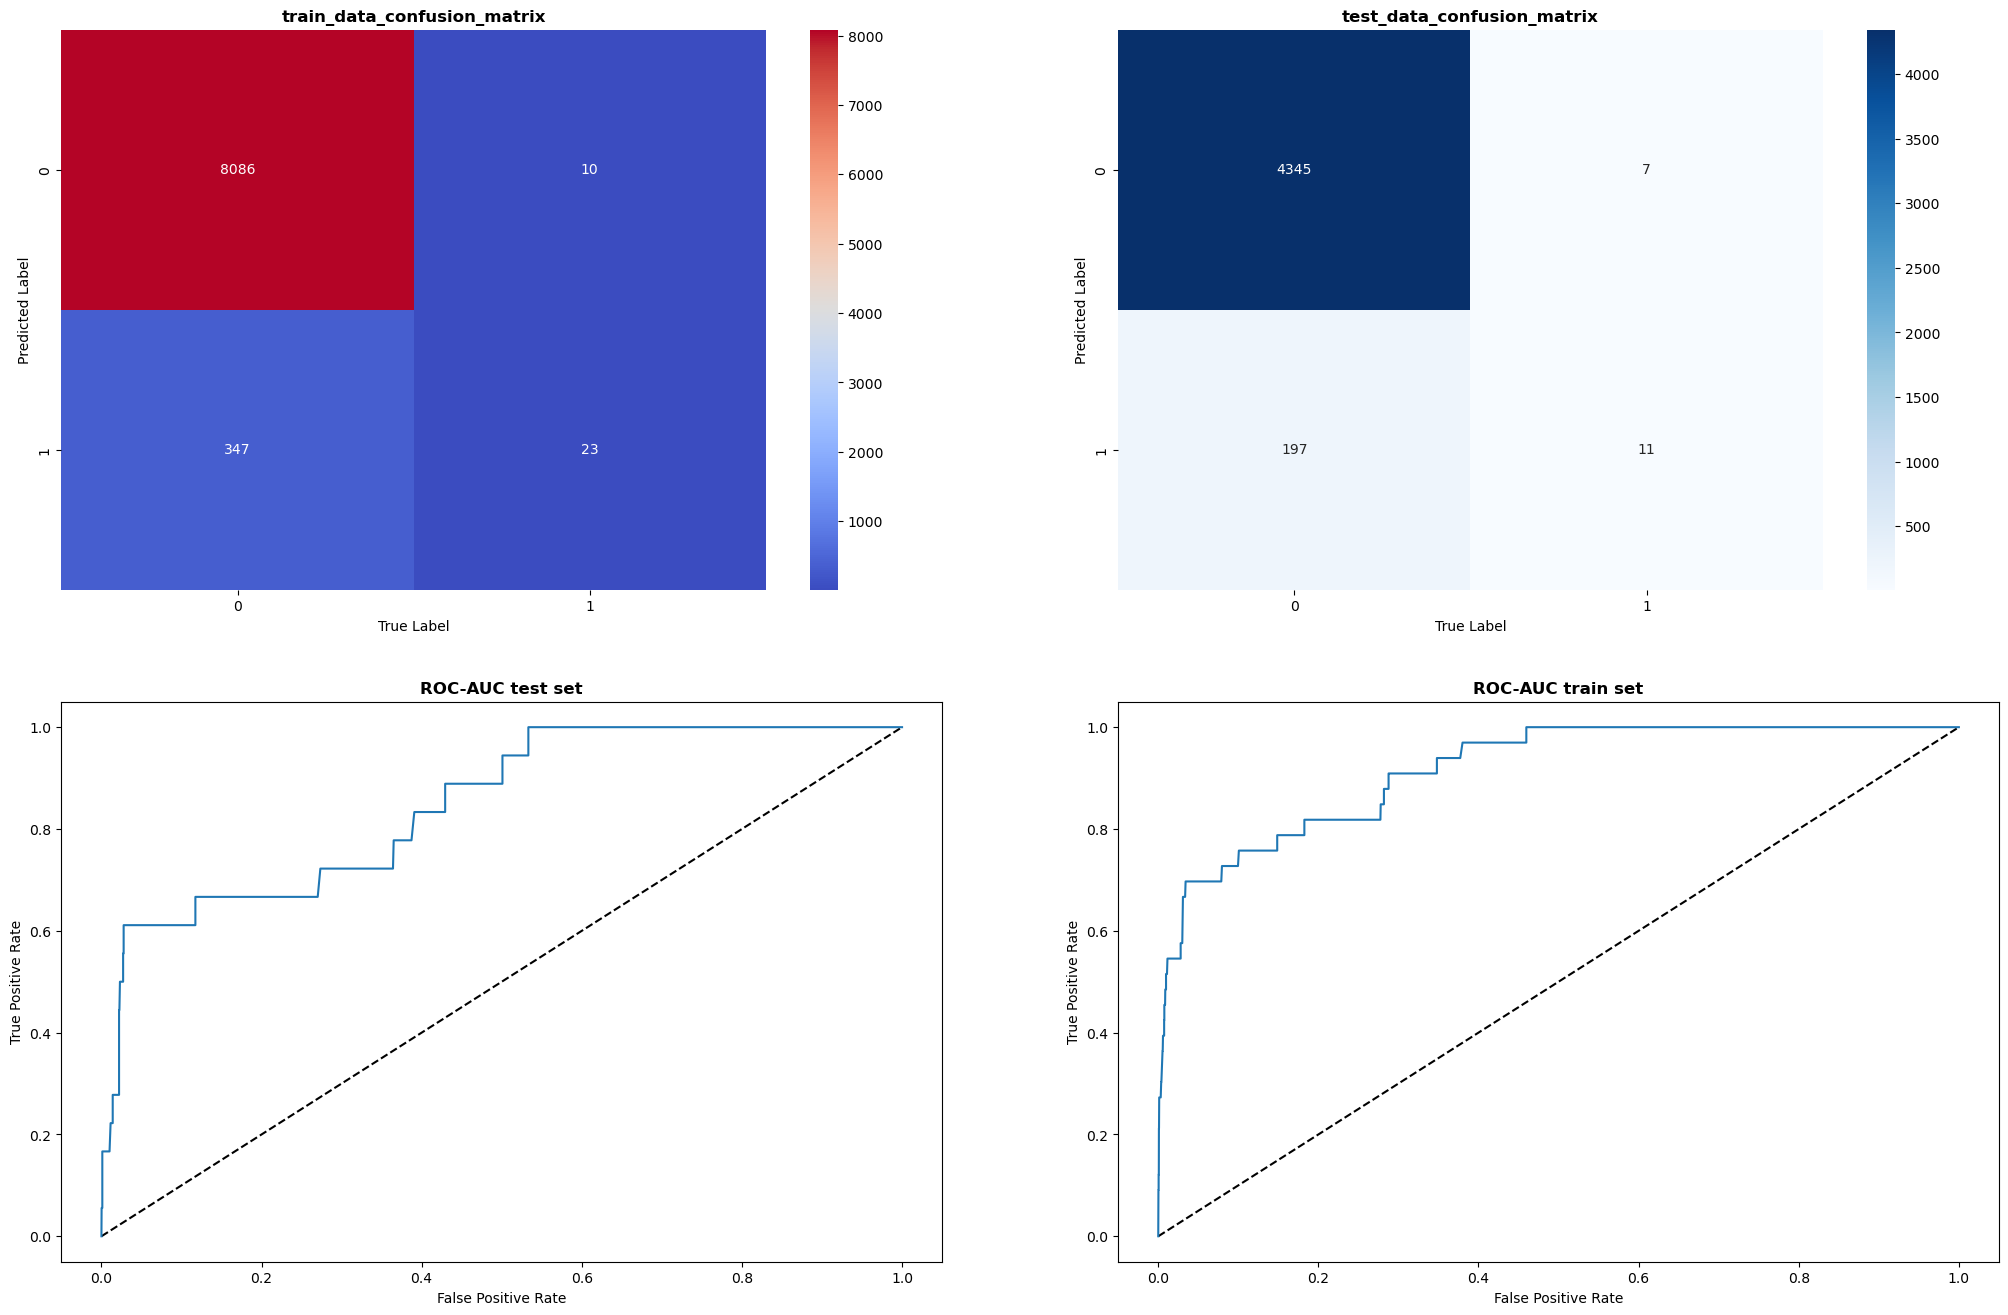

In [26]:
get_some_metric(RF_model)

In [32]:
#get classification reports
Y_pred = RF_model.predict(X_test)
clf_rpt_test = pd.DataFrame(classification_report(Y_pred,Y_test,output_dict=True)).style.set_caption("Classification Report of test output")
#test classification report
clf_rpt_train = pd.DataFrame(classification_report(RF_model.predict(X_train),Y_train,output_dict=True)).style.set_caption("Classification Report of train set")
#train classification report

In [33]:
clf_rpt_train

,0,1,accuracy,macro avg,weighted avg
precision,0.958852,0.696970,0.957831,0.827911,0.947407
recall,0.998765,0.062162,0.957831,0.530463,0.957831
f1-score,0.978402,0.114144,0.957831,0.546273,0.940630
support,8096.000000,370.000000,0.957831,8466.000000,8466.000000


In [34]:
clf_rpt_test

,0,1,accuracy,macro avg,weighted avg
precision,0.956627,0.611111,0.955263,0.783869,0.940867
recall,0.998392,0.052885,0.955263,0.525638,0.955263
f1-score,0.977063,0.097345,0.955263,0.537204,0.936936
support,4352.000000,208.000000,0.955263,4560.000000,4560.000000


In [39]:
rf_mdl = RF_model.best_estimator_

In [41]:
importances = rf_mdl.feature_importances_

# Print the feature importances
for feature, importance in zip(range(X.shape[1]), importances):
    print('Feature %d: %f' % (feature, importance))

Feature 0: 0.052984
Feature 1: 0.004958
Feature 2: 0.041728
Feature 3: 0.054279
Feature 4: 0.000969
Feature 5: 0.000000
Feature 6: 0.000000
Feature 7: 0.000000
Feature 8: 0.000000
Feature 9: 0.014834
Feature 10: 0.034315
Feature 11: 0.094280
Feature 12: 0.033397
Feature 13: 0.225739
Feature 14: 0.088346
Feature 15: 0.014767
Feature 16: 0.000000
Feature 17: 0.339404


In [44]:
Important cols : 1. it_city, 2. 

Index(['Intro View', 'Audio Journey', 'Self Explore', 'Accessories', 'EMI',
       'Exchange', 'Finance', 'Test Drive', 'Terms & Condition', 'Model ID',
       'Variant ID', 'Showroom Price', 'Accessories price', 'first_visit',
       'Hour', 'Day', 'days_since_created', 'it_city'],
      dtype='object')